In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import pickle
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

import matplotlib.cm as cm
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 /root/.kaggle/kaggle.json

In [2]:
! kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
 99% 305M/309M [00:06<00:00, 14.6MB/s]
100% 309M/309M [00:06<00:00, 50.3MB/s]


In [3]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/datasets/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/datasets/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/datasets/EmotionsD

In [ ]:
!mv "/content/resnet.keras" "/content/drive/MyDrive"

In [4]:
traindir = "/content/datasets/Emotions Dataset/Emotions Dataset/train"
validdir = "/content/datasets/Emotions Dataset/Emotions Dataset/test"
classname = ["angry","happy","sad"]

In [5]:
train = tf.keras.utils.image_dataset_from_directory(
    traindir,
    labels = "inferred",
    label_mode="categorical",
    class_names = classname,
    color_mode = "rgb",
    batch_size = 32,
    image_size = (255,255),
    shuffle = True,
    seed = 99
    )

Found 6799 files belonging to 3 classes.


In [6]:
valid = tf.keras.utils.image_dataset_from_directory(
    validdir,
    labels = "inferred",
    label_mode = "categorical",
    class_names = classname,
    color_mode = "rgb",
    batch_size = 32,
    image_size = (255,255),
    shuffle = True,
    seed = 99
)

Found 2278 files belonging to 3 classes.


In [9]:
IMG = 224

In [ ]:
for img, labels in valid.take(1):
  print(labels)

tf.Tensor(
[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]], shape=(32, 3), dtype=float32)


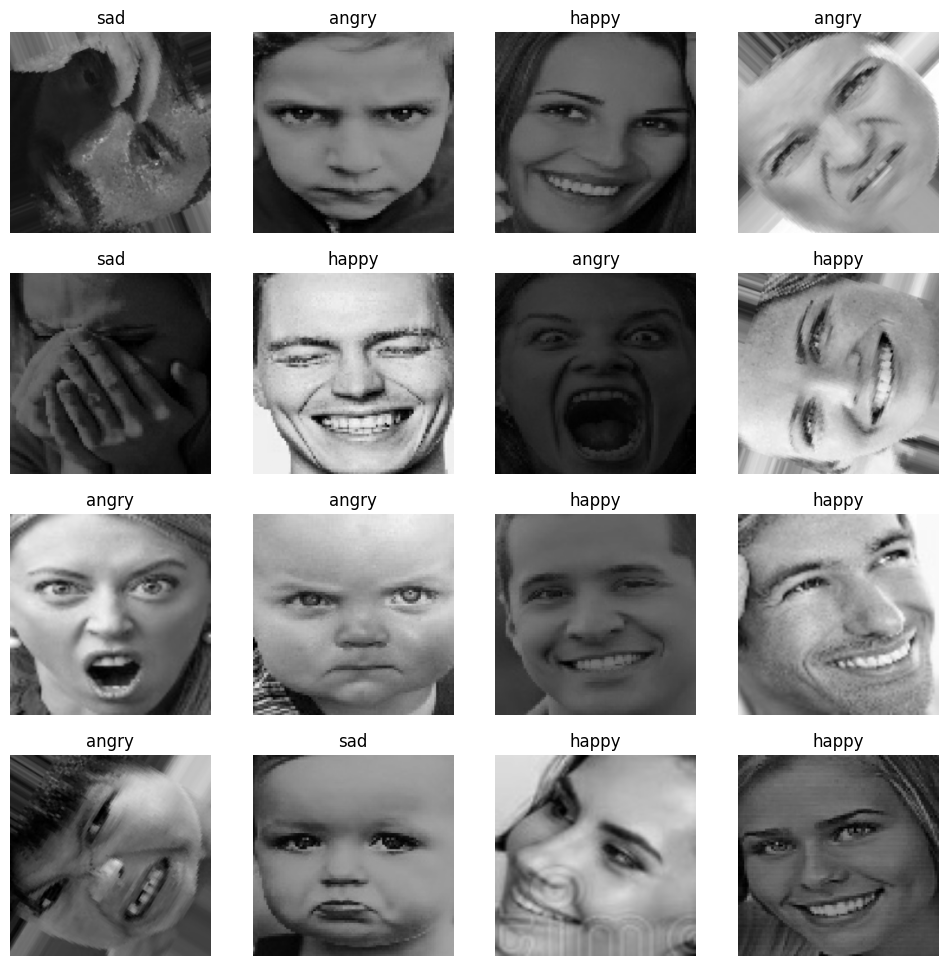

In [ ]:
plt.figure(figsize=(12,12))
for i,l in train.take(1):
  for x in range(16):
    ax = plt.subplot(4,4,x+1)
    ax.imshow(i[x]/255)
    plt.title(classname[tf.argmax(l[x], axis = 0).numpy()])
    plt.axis("off")

#TFRecords

In [ ]:
train_dataset = (
    train
    .unbatch()
)

In [ ]:
# val_dataset = (
#     validation_dataset
#     .unbatch()
# )

In [ ]:
train_dataset

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

In [ ]:
# val_dataset

In [ ]:
def create_example(image, label):

  bytes_feature = Feature(
      bytes_list=BytesList(value=[image]))

  int_feature = Feature(
      int64_list=Int64List(value=[label]))

  example = Example(
      features=Features(feature={
          'images': bytes_feature,
          'labels': int_feature,
      }))

  return example.SerializeToString()

In [ ]:
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [ ]:
def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image,tf.argmax(label)

In [ ]:
encoded_dataset = (
  train_dataset
  .map(encode_image)
)
for i in encoded_dataset.take(2):
  print(i)
print(encoded_dataset)

(<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x01\x00\x01\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87

In [ ]:
for shard_number in range(NUM_SHARDS):

  sharded_dataset = (
      encoded_dataset
      .shard(NUM_SHARDS, shard_number)
      .as_numpy_iterator()
  )

  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    for encoded_image, encoded_label in sharded_dataset:

      example = create_example(encoded_image, encoded_label)
      file_writer.write(example)

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
recons_dataset = tf.data.TFRecordDataset(
    filenames =[PATH.format(p) for p in range(NUM_SHARDS-2)] )
# val_recons_dataset = tf.data.TFRecordDataset(
#     filenames =[PATH.format(p) for p in range(NUM_SHARDS-2,NUM_SHARDS)] )


In [ ]:
for i in recons_dataset.take(2):
  print(i)

tf.Tensor(b'\n\xf4\x10\n\x0f\n\x06labels\x12\x05\x1a\x03\n\x01\x01\n\xe0\x10\n\x06images\x12\xd5\x10\n\xd2\x10\n\xcf\x10\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x01\x00\x01\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x1

In [ ]:
def parse_tfrecords(example):

    feature_description = {
          "images": tf.io.FixedLenFeature([], tf.string),
          "labels": tf.io.FixedLenFeature([], tf.int64),
    }

    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(
        example["images"], channels = 3), dtype = tf.float32)

    return example["images"], example["labels"]


In [ ]:
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
# val_parsed_dataset = (
#     val_recons_dataset
#     .map(parse_tfrecords)
#     .batch(CONFIGURATION["BATCH_SIZE"])
#     .prefetch(tf.data.AUTOTUNE)
# )


In [ ]:
parsed_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
for i in parsed_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=uint8, numpy=
array([[[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        ...,

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 2

In [ ]:
ds = tf.data.TFRecordDataset(['/content/tfrecords/shard_00.tfrecord'])
for batch in ds.take(1):
  example = tf.train.Example()
  example.ParseFromString(batch.numpy())
  print(example)

features {
  feature {
    key: "images"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\001,\001,\000\000\377\333\000C\000\002\001\001\001\001\001\002\001\001\001\002\002\002\002\002\004\003\002\002\002\002\005\004\004\003\004\006\005\006\006\006\005\006\006\006\007\t\010\006\007\t\007\006\006\010\013\010\t\n\n\n\n\n\006\010\013\014\013\n\014\t\n\n\n\377\333\000C\001\002\002\002\002\002\002\005\003\003\005\n\007\006\007\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\377\300\000\021\010\001\000\001\000\003\001\"\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\002\001\003\003\002\004\003\005\005\004\004\000\000\001}\001\002\003\000\004\021\005\022!1A\006\023Qa\007\"q\0242\201\221\241\010#B\261\301\025R\321\360$3br\202\t\n\026\027\030\031\032%&\'()*456789:CDEFGHI

In [ ]:
parsed_data = (
    ds
    .map(parse_tfrecords)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
for i in parsed_data.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[1.       , 1.       , 1.       ],
         [1.       , 1.       , 1.       ],
         [1.       , 1.       , 1.       ],
         ...,
         [1.       , 1.       , 1.       ],
         [1.       , 1.       , 1.       ],
         [1.       , 1.       , 1.       ]],

        [[1.       , 1.       , 1.       ],
         [1.       , 1.       , 1.       ],
         [1.       , 1.       , 1.       ],
         ...,
         [1.       , 1.       , 1.       ],
         [1.       , 1.       , 1.       ],
         [1.       , 1.       , 1.       ]],

        [[1.       , 1.       , 1.       ],
         [1.       , 1.       , 1.       ],
         [1.       , 1.       , 1.       ],
         ...,
         [1.       , 1.       , 1.       ],
         [1.       , 1.       , 1.       ],
         [1.       , 1.       , 1.       ]],

        ...,

        [[1.       , 1.       , 1.       ],
         [1.       , 1.       , 1.       ]

TENSORFLOW RECORDS


In [ ]:
recordtrain = (
    train
    .unbatch()
)

In [ ]:
validtrain=(
    train
    .unbatch()
)


In [ ]:
def encodeimage(image, label):
  image = tf.image.convert_image_dtype(image, dtype = tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image, label

encodedata=(
    recordtrain
    .map(encodeimage)
)


def recordexample(image, label):

  bytefeature = tf.train.Feature(
      bytes_list = tf.train.BytesList(value=[tf.io.encode_jpeg(image).numpy()])
  )
  intfeature = tf.train.Feature(
      int64_list = tf.train.Int64List(value=[tf.argmax(label, axis =0)])
  )
  example = tf.train.Example(
      features = tf.train.Features(
          feature = {
              'image': bytefeature,
              'label': intfeature
          }
      )
  )
  return example.SerializeToString()

In [ ]:
numshards = 10
path = 'tfrecords/shard{:02}.tfrecord'
for shardnum in range(numshards):
  sharddata = (
      recordtrain
      .shard(numshards, shardnum)
      .as_numpy_iterator()
  )
  with tf.io.TFRecordWriter(path.format(shardnum)) as writer:
    for image, label in sharddata:
      writer.write(recordexample(image,label))

In [ ]:
print([path.format(p) for p in range(numshards)])

['tfrecords/shard00.tfrecord', 'tfrecords/shard01.tfrecord', 'tfrecords/shard02.tfrecord', 'tfrecords/shard03.tfrecord', 'tfrecords/shard04.tfrecord', 'tfrecords/shard05.tfrecord', 'tfrecords/shard06.tfrecord', 'tfrecords/shard07.tfrecord', 'tfrecords/shard08.tfrecord', 'tfrecords/shard09.tfrecord']


In [ ]:
recontructdata = tf.data.TFRecordDataset(
    filenames= [path.format(p)for p in range(numshards)]
)

In [ ]:
def parse_tfrecords(example):

    feature_description = {
          'image': tf.io.FixedLenFeature([], tf.string),
          'label': tf.io.FixedLenFeature([], tf.int64),
      }

    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(
        example["image"], channels = 3), dtype = tf.float32)

    return example['image'], tf.one_hot(example['label'], depth = 3)

In [ ]:
parseddata = (
    recontructdata
    .map(parse_tfrecords)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)
parseddata

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
for image, label in parseddata.take(1):
  print(image)
  print(label)

tf.Tensor(
[[[[0.09803922 0.09803922 0.09803922]
   [0.09411766 0.09411766 0.09411766]
   [0.09019608 0.09019608 0.09019608]
   ...
   [0.40784317 0.40784317 0.40784317]
   [0.3921569  0.3921569  0.3921569 ]
   [0.3803922  0.3803922  0.3803922 ]]

  [[0.09411766 0.09411766 0.09411766]
   [0.09019608 0.09019608 0.09019608]
   [0.09019608 0.09019608 0.09019608]
   ...
   [0.41176474 0.41176474 0.41176474]
   [0.39607847 0.39607847 0.39607847]
   [0.38823533 0.38823533 0.38823533]]

  [[0.09019608 0.09019608 0.09019608]
   [0.09411766 0.09411766 0.09411766]
   [0.09411766 0.09411766 0.09411766]
   ...
   [0.41176474 0.41176474 0.41176474]
   [0.40000004 0.40000004 0.40000004]
   [0.38823533 0.38823533 0.38823533]]

  ...

  [[0.04313726 0.04313726 0.04313726]
   [0.04313726 0.04313726 0.04313726]
   [0.04705883 0.04705883 0.04705883]
   ...
   [0.67058825 0.67058825 0.67058825]
   [0.7137255  0.7137255  0.7137255 ]
   [0.7176471  0.7176471  0.7176471 ]]

  [[0.04313726 0.04313726 0.043137

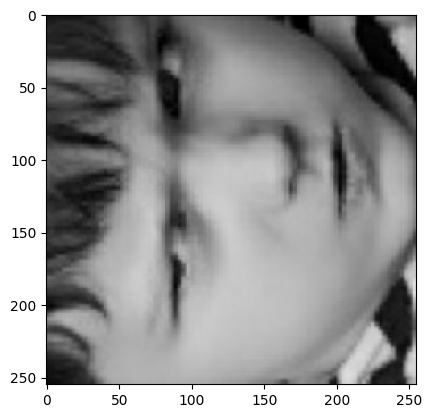

In [ ]:
im,label = next(iter(parseddata))
plt.imshow(im[0])

In [ ]:
@tf.function
def box(lambda1):
  xpoint=tf.cast(tfp.distributions.Uniform(0,IMG).sample(1)[0], dtype = tf.int32)
  ypoint=tf.cast(tfp.distributions.Uniform(0,IMG).sample(1)[0], dtype = tf.int32)
  wpoint = tf.cast(IMG*tf.math.sqrt(1-lambda1),dtype = tf.int32)
  hpoint = tf.cast(IMG*tf.math.sqrt(1-lambda1),dtype = tf.int32)

  xstart = tf.clip_by_value(xpoint-wpoint//2, 0,IMG)
  ystart = tf.clip_by_value(ypoint-hpoint//2, 0,IMG)
  xend = tf.clip_by_value(xpoint+wpoint//2, 0,IMG)
  yend = tf.clip_by_value(ypoint+hpoint//2, 0,IMG)

  wupdated = xend - xstart
  if(wupdated == 0):
    wupdated = 1
  hupdated = yend - ystart
  if(hupdated == 0):
    hupdated = 1

  return xstart, ystart, wupdated, hupdated



In [ ]:
@tf.function
def cutmix(data1,data2):
  lambdabeta = tfp.distributions.Beta(0.2,0.2).sample(1)[0]
  (img1,lab1),(img2,lab2) = data1, data2
  x,y,w,h = box(lambdabeta)

  crop1 = tf.image.crop_to_bounding_box(img1,y,x,h,w)
  pad1 = tf.image.pad_to_bounding_box(crop1,y,x,IMG,IMG)

  crop2 = tf.image.crop_to_bounding_box(img2,y,x,h,w)
  pad2 = tf.image.pad_to_bounding_box(crop2,y,x,IMG,IMG)

  updatedimage = img1 - pad1 + pad2

  cutlambda = 1 - (w*h)/(IMG*IMG)

  updatedlabel = cutlambda*tf.cast(lab1, dtype = tf.float64) + (1-cutlambda)*tf.cast(lab2, dtype = tf.float64)

  return updatedimage, updatedlabel



In [ ]:
@tf.function
def gray(img,label):
  return tf.image.rgb_to_grayscale(img), label

In [10]:
augmentlayers = Sequential([

    RandomContrast(0.2),
    RandomRotation((-0.025,0.025)),
    Resizing(IMG,IMG),
    Rescaling(1/IMG),
])

In [11]:
@tf.function
def augment(img, label):
  return augmentlayers(img, training =True), label

In [ ]:
traindata1 =train.map(augment, num_parallel_calls = tf.data.AUTOTUNE)

traindata2 =train.map(augment, num_parallel_calls = tf.data.AUTOTUNE)


mixed = tf.data.Dataset.zip((traindata1,traindata2))

# train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
# train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

# mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [ ]:
cutmixdataset =mixed.map(cutmix, num_parallel_calls = tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)


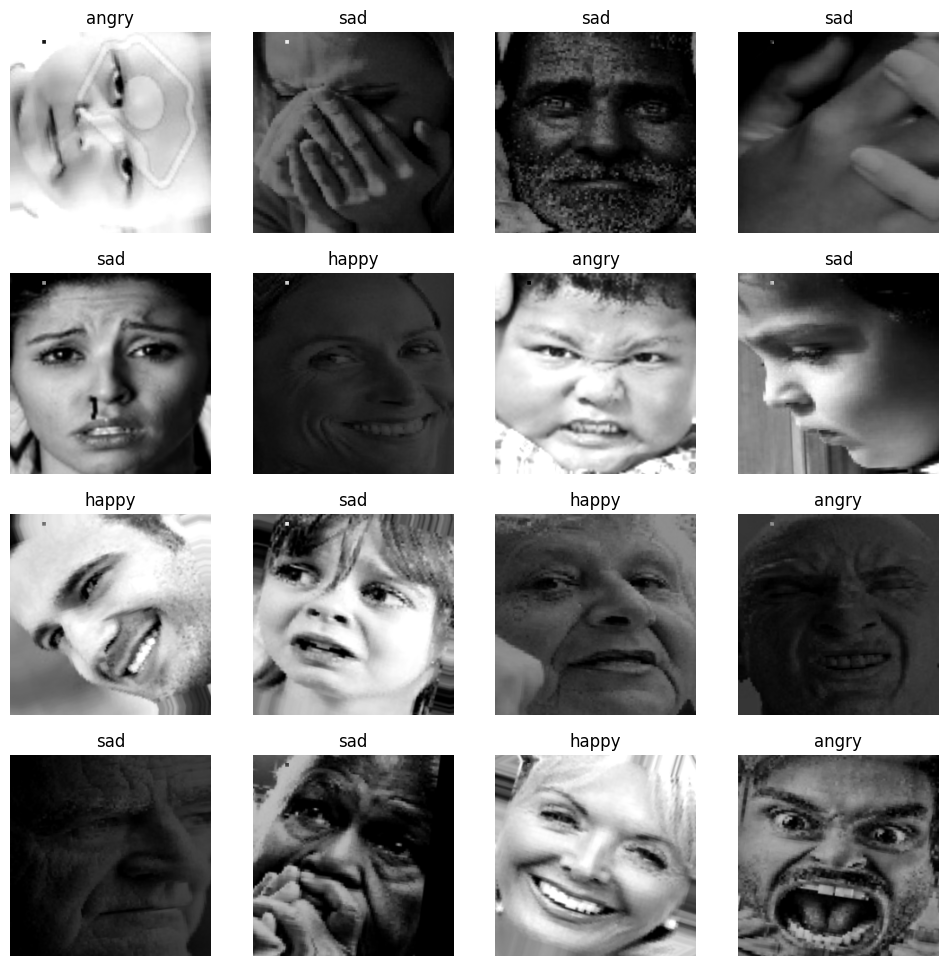

In [ ]:
plt.figure(figsize=(12,12))
for i,l in cutmixdataset.take(1):
  for x in range(16):
    ax = plt.subplot(4,4,x+1)
    ax.imshow(i[x])
    plt.title(classname[tf.argmax(l[x], axis = 0).numpy()])
    plt.axis("off")

In [12]:
traindataset = (
    train
    .map(augment, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)


In [13]:
validdataset = (
    valid
    .map(augment, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [14]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IMG,IMG),
    Rescaling(1/255),
])

In [ ]:
input = InputLayer(input_shape = (None,None,3))

class lenet(Model):
  def __init__(self):
    super(lenet, self).__init__()
    self.resize = resize_rescale_layers
    self.conv1 = Conv2D(filters = 6, kernel_size = 3, strides = 1, activation = "relu", kernel_regularizer = L2(0.0001))
    self.conv2 = Conv2D(filters = 12, kernel_size = 3, strides = 1, activation = "relu", kernel_regularizer = L2(0.0001))
    self.batch = BatchNormalization()
    self.batch1 = BatchNormalization()
    self.batch2 = BatchNormalization()
    self.batch3 = BatchNormalization()
    self.batch4 = BatchNormalization()
    self.maxp = MaxPool2D(pool_size=(2,2))
    self.drop = Dropout(0.3)
    self.flatten = Flatten()
    self.dense1 = Dense(1024, activation = "relu")
    self.dense2 = Dense(512, activation = "relu")
    self.dense3 = Dense(128, activation = "relu")
    self.dense4 = Dense(3, activation = "softmax")

  def call(self, x, training):
    x = self.resize(x)
    x = self.conv1(x)
    x = self.batch(x)
    x = self.maxp(x)
    x = self.drop(x)
    x = self.conv2(x)
    x = self.batch1(x)
    x = self.maxp(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.batch2(x)
    x = self.drop(x)
    x = self.dense3(x)
    x = self.batch3(x)
    x = self.dense4(x)
    return x

lemodel = lenet()
lemodel.build(input_shape = (None,None,None,3))
lemodel.summary()


NameError: name 'resize_rescale_layers' is not defined

In [15]:
IMG = 255
class alexnet(Model):
  def __init__(self):
    super(alexnet, self).__init__()
    self.augment = augmentlayers
    self.conv1 = Conv2D(filters = 96, kernel_size = 11, strides = 4, activation = "relu")
    self.batch1 = BatchNormalization()
    self.maxp1 = MaxPool2D(pool_size=(3,3), strides = 2)
    self.drop1 = Dropout(0.5)
    self.conv2 = Conv2D(filters = 256, kernel_size = 5, strides = 1, activation = "relu")
    self.batch2 = BatchNormalization()
    self.maxp2 = MaxPool2D(pool_size=(3,3), strides = 2)
    self.conv3 = Conv2D(filters = 384, kernel_size = 3, strides = 1, activation = "relu")
    self.batch3 = BatchNormalization()
    self.drop2 = Dropout(0.5)
    self.conv4 = Conv2D(filters = 384, kernel_size = 3, strides = 1, activation = "relu")
    self.batch4 = BatchNormalization()
    self.conv5 = Conv2D(filters = 256, kernel_size = 3, strides = 1, activation = "relu")
    self.batch5 = BatchNormalization()
    self.maxp3 = MaxPool2D(pool_size=(3,3), strides = 2)
    self.flatten = Flatten()
    self.dense1 = Dense(9216, activation = "relu")
    self.batch6 = BatchNormalization()
    self.drop3 = Dropout(0.5)
    self.dense2 = Dense(4096, activation = "relu")
    self.batch7 = BatchNormalization()
    self.dense3 = Dense(1000, activation = "relu")
    self.batch8 = BatchNormalization()
    self.dense4 = Dense(128, activation = "relu")
    self.batch9 = BatchNormalization()
    self.dense5 = Dense(3, activation="softmax")

  def call(self, x, training):
    x = self.augment(x)
    x = self.conv1(x)
    x = self.batch1(x)
    x = self.maxp1(x)
    x = self.drop1(x)
    x = self.conv2(x)
    x = self.batch2(x)
    x = self.maxp2(x)
    x = self.conv3(x)
    x = self.batch3(x)
    x = self.drop2(x)
    x = self.conv4(x)
    x = self.batch4(x)
    x = self.conv5(x)
    x = self.batch5(x)
    x = self.maxp3(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.batch6(x)
    x = self.drop3(x)
    x = self.dense2(x)
    x = self.batch7(x)
    x = self.dense3(x)
    x = self.batch8(x)
    x = self.dense4(x)
    x = self.batch9(x)
    x = self.dense5(x)
    return x

alexmodel = alexnet()
output = alexmodel(tf.ones((1, 256, 128, 3)), training = True)
alexmodel.summary()

Model: "alexnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (1, 54, 54, 96)             │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (1, 54, 54, 96)             │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (1, 26, 26, 96)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (1, 26, 26, 96)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (1, 22, 22, 256)            │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (1, 22, 22, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (1, 10, 10, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (1, 8, 8, 384)              │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (1, 8, 8, 384)              │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (1, 8, 8, 384)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (1, 6, 6, 384)              │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (1, 6, 6, 384)              │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (1, 4, 4, 256)              │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (1, 4, 4, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (1, 1, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (1, 256)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 9216)                   │       2,368,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (1, 9216)                   │          36,8

 Total params: 48,157,323 (183.71 MB)

 Trainable params: 48,125,691 (183.58 MB)

 Non-trainable params: 31,632 (123.56 KB)

In [16]:
IMG = 255
alexnet_sequential = Sequential([
    # Augmentation layer
    InputLayer(input_shape=(IMG,IMG,3)),  # Input layer
    augmentlayers,

    # First Conv Block
    Conv2D(filters=96, kernel_size=11, strides=4, activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3, 3), strides=2),
    Dropout(0.5),

    # Second Conv Block
    Conv2D(filters=256, kernel_size=5, strides=1, activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3, 3), strides=2),

    # Third Conv Block
    Conv2D(filters=384, kernel_size=3, strides=1, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),

    # Fourth Conv Block
    Conv2D(filters=384, kernel_size=3, strides=1, activation="relu"),
    BatchNormalization(),

    # Fifth Conv Block
    Conv2D(filters=256, kernel_size=3, strides=1, activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3, 3), strides=2),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(9216, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4096, activation="relu"),
    BatchNormalization(),
    Dense(1000, activation="relu"),
    BatchNormalization(),
    Dense(128, activation="relu"),
    BatchNormalization(),

    # Output Layer (Softmax for 3 classes)
    Dense(3, activation="softmax")
])

# Test the model with dummy input
output = alexnet_sequential(tf.ones((1, 256, 128, 3)))
alexnet_sequential.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 54, 54, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 54, 54, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 26, 26, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 26, 26, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 22, 22, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 22, 22, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 8, 8, 384)           │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8, 8, 384)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 6, 6, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 6, 6, 384)           │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 4, 4, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9216)                │       2,368,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 9216)                │          36,8

 Total params: 48,157,323 (183.71 MB)

 Trainable params: 48,125,691 (183.58 MB)

 Non-trainable params: 31,632 (123.56 KB)

In [ ]:
IMG = 255
class customconv(Layer):
  def __init__(self,filternum,kernelsize,stride,act):
    super(customconv, self).__init__(name = "custom_conv2d")
    self.conv2d = Conv2D(
        filters = filternum,
        kernel_size = kernelsize,
        strides = stride,
        activation = act,
        padding = "same"
    )
    self.batch = BatchNormalization()

  def call(self, x ,training = True):
      x=self.conv2d(x)
      x=self.batch(x, training=training) #Pass training as a keyword argument.

      return x



In [ ]:
class residual(Layer):
  def __init__(self, channels, numstrides=1):
    super(residual,self).__init__(name = "custom_residual_block")
    self.skip = (numstrides!=1)
    self.con1 = customconv(channels,3,numstrides,"relu")
    self.con2 = customconv(channels,3,1,"relu")
    self.activation = Activation("relu")

    if self.skip:
      self.skipcon = customconv(channels,1,numstrides,"relu")

  def call(self, input,training): # No change is needed here
    x1 = self.con1(input,training=training) # Pass training as a keyword argument
    x = self.con2(x1,training=training) # Pass training as a keyword argument
    if self.skip:
      skipx = self.skipcon(input,training=training) # Pass training as a keyword argument
      final = Add()([x,skipx])
    else:
      final =Add()([x,input])


    return self.activation(final)

In [ ]:
class resnet34model(Model):
  def __init__(self):
    super(resnet34model, self).__init__()
    self.augment = augmentlayers
    self.conv1 = customconv(64,7,2,"relu")
    self.maxp = MaxPool2D(pool_size=(3,3),strides = 2)

    self.res11 = residual(64)
    self.res12 = residual(64)
    self.res13 = residual(64)

    self.res21 = residual(128,2)
    self.res22 = residual(128)
    self.res23= residual(128)
    self.res24 = residual(128)

    self.res31 = residual(256,2)
    self.res32 = residual(256)
    self.res33 = residual(256)
    self.res34 = residual(256)
    self.res35 = residual(256)
    self.res36 = residual(256)

    self.res41 = residual(512,2)
    self.res42 = residual(512)
    self.res43 = residual(512)

    self.globalpool = GlobalAveragePooling2D()
    self.den = Dense(3,activation = "softmax")

  def call(self,x, training= True): # No change is needed here
    x = self.augment(x)
    x = self.conv1(x)
    x = self.maxp(x)
    x = self.res11(x,training=training) # Pass training as a keyword argument
    x = self.res12(x,training=training) # Pass training as a keyword argument
    x = self.res13(x,training=training) # Pass training as a keyword argument
    x = self.res21(x,training=training) # Pass training as a keyword argument
    x = self.res22(x,training=training) # Pass training as a keyword argument
    x = self.res23(x,training=training) # Pass training as a keyword argument
    x = self.res24(x,training=training) # Pass training as a keyword argument
    x = self.res31(x,training=training) # Pass training as a keyword argument
    x = self.res32(x,training=training) # Pass training as a keyword argument
    x = self.res33(x,training=training) # Pass training as a keyword argument
    x = self.res34(x,training=training) # Pass training as a keyword argument
    x = self.res35(x,training=training) # Pass training as a keyword argument
    x = self.res36(x,training=training) # Pass training as a keyword argument
    x = self.res41(x,training=training) # Pass training as a keyword argument
    x = self.res42(x,training=training) # Pass training as a keyword argument
    x = self.res43(x,training=training) # Pass training as a keyword argument
    x = self.globalpool(x)
    x = self.den(x)
    return x


resnet34=resnet34model()
resnet34(tf.zeros((1,224,224,3))) # No change is needed here
resnet34.summary()

Model: "resnet34model_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_conv2d (customconv)           │ ?                           │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (1, 55, 55, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_residual_block (residual)     │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_residual_block (residual)     │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_residual_block (residual)     │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_residual_block (residual)     │ ?                           │         231,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_residual_block (residual)     │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_residual_block (residual)     │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_residual_block (residual)     │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_residual_block (residual)     │ ?                           │         921,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_residual_block (residual)     │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_residual_block (residual)     │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_residual_block (residual)     │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_residual_block (residual)     │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_residual_block (residual)     │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_residual_block (residual)     │ ?                           │       3,677,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_residual_block (residual)     │ ?                           │       4,723,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_residual_block (residual)     │ ?                           │       4,723,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (1, 512)                    │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (1, 3)                      │           1,5

 Total params: 21,311,747 (81.30 MB)

 Trainable params: 21,294,723 (81.23 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [ ]:
efficientmodel = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top = False,
    weights = "imagenet",
    input_shape = (IMG,IMG,3)
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
efficientmodel.trainable = False

In [ ]:
IMG = 255
efficient = Sequential([
    InputLayer(input_shape=(IMG,IMG,3)),
    augmentlayers,
    efficientmodel,
    GlobalAveragePooling2D(),
    Dense(1028, activation = 'relu'),
    BatchNormalization(),
    Dense(128, activation = 'relu'),
    Dense(3, activation = 'softmax'),
])
efficient.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1028)                │       1,316,868 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1028)                │           4,112 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         131,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,711,063 (14.16 MB)

 Trainable params: 3,674,895 (14.02 MB)

 Non-trainable params: 36,168 (141.28 KB)

In [ ]:
fine = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top = False,
    weights = "imagenet",
    input_shape = (IMG,IMG,3)
)

In [ ]:
fine.trainable = True

In [ ]:
IMG=224
inn = Input(shape = (IMG,IMG,3))
x = fine(inn)
x = GlobalAveragePooling2D()(x)
x = Dense(1028, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation = 'relu')(x)
out = Dense(3, activation = 'softmax')(x)

finemobile = Model(inputs = inn,  outputs = out)
finemobile.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1028)                │       1,316,868 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1028)                │           4,112 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │         131,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,711,063 (14.16 MB)

 Trainable params: 3,674,895 (14.02 MB)

 Non-trainable params: 36,168 (141.28 KB)

In [17]:
lrcallback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "cataccuracy",
    factor = 0.1,
    patience = 3,
    verbose = 0,
    mode = "auto",
    min_delta = 0.01,
)

In [18]:
loss = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name = 'cataccuracy'), TopKCategoricalAccuracy(2, name = 'top2accuracy')]
optimizer = Adam(learning_rate = 0.001)

In [ ]:
with tf.device('/device:GPU:0'):
  finemobile.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  finehis = finemobile.fit(traindataset, epochs = 15, validation_data = validdataset, verbose = 1)

Epoch 1/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 139s 497ms/step - cataccuracy: 0.6683 - loss: 0.3399 - top2accuracy: 0.8486 - val_cataccuracy: 0.4543 - val_loss: 28.0838 - val_top2accuracy: 0.6677
Epoch 2/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 93s 345ms/step - cataccuracy: 0.8193 - loss: 0.4988 - top2accuracy: 0.9424 - val_cataccuracy: 0.5022 - val_loss: 19.7840 - val_top2accuracy: 0.6677
Epoch 3/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 77s 362ms/step - cataccuracy: 0.8536 - loss: 0.3773 - top2accuracy: 0.9556 - val_cataccuracy: 0.4315 - val_loss: 4.4349 - val_top2accuracy: 0.7766
Epoch 4/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 77s 360ms/step - cataccuracy: 0.8368 - loss: 0.4216 - top2accuracy: 0.9566 - val_cataccuracy: 0.6607 - val_loss: 2.1161 - val_top2accuracy: 0.8854
Epoch 5/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 80s 351ms/step - cataccuracy: 0.8844 - loss: 0.3102 - top2accuracy: 0.9666 - val_cataccuracy: 0.5514 - val_loss: 2.1029 - val_top2accuracy: 0.8784
Epoch 6/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 74s 348ms/step - catac

In [ ]:
with tf.device('/device:GPU:0'):
  efficient.compile(optimizer = optimizer, loss = loss, metrics = metrics)

  effhis = efficient.fit(traindataset,epochs = 18, validation_data = validdataset, verbose = 1, callbacks=[lrcallback])

Epoch 1/18
213/213 ━━━━━━━━━━━━━━━━━━━━ 131s 434ms/step - cataccuracy: 0.6044 - loss: 1.0651 - top2accuracy: 0.8439 - val_cataccuracy: 0.4416 - val_loss: 6.9132 - val_top2accuracy: 0.7739 - learning_rate: 0.0010
Epoch 2/18
213/213 ━━━━━━━━━━━━━━━━━━━━ 128s 403ms/step - cataccuracy: 0.7837 - loss: 0.5195 - top2accuracy: 0.9374 - val_cataccuracy: 0.4416 - val_loss: 3.8193 - val_top2accuracy: 0.6677 - learning_rate: 0.0010
Epoch 3/18
213/213 ━━━━━━━━━━━━━━━━━━━━ 90s 423ms/step - cataccuracy: 0.8296 - loss: 0.4352 - top2accuracy: 0.9533 - val_cataccuracy: 0.4416 - val_loss: 3.0985 - val_top2accuracy: 0.7735 - learning_rate: 0.0010
Epoch 4/18
213/213 ━━━━━━━━━━━━━━━━━━━━ 90s 422ms/step - cataccuracy: 0.8206 - loss: 0.4381 - top2accuracy: 0.9509 - val_cataccuracy: 0.4416 - val_loss: 4.0242 - val_top2accuracy: 0.6677 - learning_rate: 0.0010
Epoch 5/18
213/213 ━━━━━━━━━━━━━━━━━━━━ 143s 426ms/step - cataccuracy: 0.8188 - loss: 0.4841 - top2accuracy: 0.9422 - val_cataccuracy: 0.4416 - val_loss: 

KeyboardInterrupt: 

In [ ]:
efficient.evaluate(validdataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - cataccuracy: 0.4376 - loss: 50.1129 - top2accuracy: 0.6609


[49.53030014038086, 0.4416154623031616, 0.6676909327507019]

In [ ]:
with open('/content/model.pkl','wb') as f:
    pickle.dump(efficient, f)

NameError: name 'efficient' is not defined

In [ ]:
resnet34.compile(optimizer = optimizer, loss = loss, metrics = metrics)

In [ ]:
with tf.device('/device:GPU:0'):
  hisrestnet = resnet34.fit(traindataset,epochs = 18, validation_data = validdataset, verbose = 1, callbacks=[lrcallback])

Epoch 1/18
213/213 ━━━━━━━━━━━━━━━━━━━━ 121s 435ms/step - cataccuracy: 0.4489 - loss: 1.4648 - top2accuracy: 0.7560 - val_cataccuracy: 0.4416 - val_loss: 1.2900 - val_top2accuracy: 0.7739 - learning_rate: 0.0010
Epoch 2/18
213/213 ━━━━━━━━━━━━━━━━━━━━ 132s 407ms/step - cataccuracy: 0.5256 - loss: 1.0134 - top2accuracy: 0.8074 - val_cataccuracy: 0.2261 - val_loss: 6.3692 - val_top2accuracy: 0.6677 - learning_rate: 0.0010
Epoch 3/18
213/213 ━━━━━━━━━━━━━━━━━━━━ 88s 410ms/step - cataccuracy: 0.5744 - loss: 0.9389 - top2accuracy: 0.8239 - val_cataccuracy: 0.3802 - val_loss: 1.4139 - val_top2accuracy: 0.7375 - learning_rate: 0.0010
Epoch 4/18
213/213 ━━━━━━━━━━━━━━━━━━━━ 94s 439ms/step - cataccuracy: 0.6039 - loss: 0.8710 - top2accuracy: 0.8478 - val_cataccuracy: 0.5768 - val_loss: 0.9733 - val_top2accuracy: 0.8459 - learning_rate: 0.0010
Epoch 5/18
213/213 ━━━━━━━━━━━━━━━━━━━━ 140s 431ms/step - cataccuracy: 0.6472 - loss: 0.7981 - top2accuracy: 0.8796 - val_cataccuracy: 0.6238 - val_loss: 

In [23]:
#save the model in .h5
import tensorflow as tf

# Assuming alexnet_sequential is your model

# Save the model using the SavedModel format, inferred from the '.keras' extension
alexnet_sequential.save("/content/seq.keras")

# To load the saved model:
# loaded_model = tf.keras.models.load_model("/content/seq.keras")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
alexnet_sequential.compile(optimizer = optimizer, loss = loss, metrics = metrics)

In [20]:
with tf.device('/device:GPU:0'):
  his = alexnet_sequential.fit(traindataset,epochs = 20, validation_data = validdataset, verbose = 1, callbacks=[lrcallback])

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 79s 329ms/step - cataccuracy: 0.4214 - loss: 1.2743 - top2accuracy: 0.7289 - val_cataccuracy: 0.4416 - val_loss: 1.2343 - val_top2accuracy: 0.7634 - learning_rate: 0.0010
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 69s 323ms/step - cataccuracy: 0.5105 - loss: 1.0070 - top2accuracy: 0.7934 - val_cataccuracy: 0.4223 - val_loss: 1.1511 - val_top2accuracy: 0.7739 - learning_rate: 0.0010
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 72s 337ms/step - cataccuracy: 0.5386 - loss: 0.9774 - top2accuracy: 0.8082 - val_cataccuracy: 0.5031 - val_loss: 1.0657 - val_top2accuracy: 0.7963 - learning_rate: 0.0010
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 78s 319ms/step - cataccuracy: 0.5639 - loss: 0.9401 - top2accuracy: 0.8268 - val_cataccuracy: 0.4991 - val_loss: 1.0224 - val_top2accuracy: 0.8090 - learning_rate: 0.0010
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 86s 340ms/step - cataccuracy: 0.5653 - loss: 0.9151 - top2accuracy: 0.8418 - val_cataccuracy: 0.5290 - val_loss: 1.1

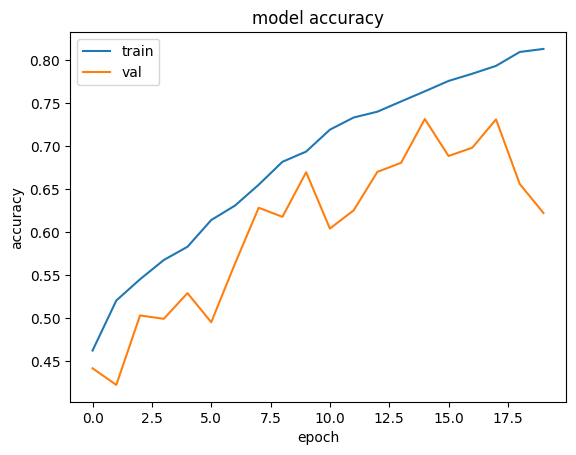

In [21]:
plt.plot(his.history['cataccuracy'])
plt.plot(his.history['val_cataccuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
backbone = tf.keras.applications.vgg16.VGG16(
    include_top = False,
    weights = "imagenet",
    input_shape = (IMG,IMG,3)
)

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
featuremap = [layer.output for layer in backbone.layers[1:]]
featuremodel = Model(
    inputs = backbone.input,
    outputs = featuremap
)
featuremodel.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

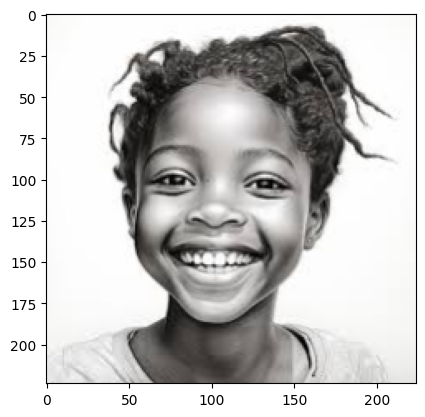

In [ ]:
img =plt.imread("/content/images-5.jpeg")
img = tf.image.convert_image_dtype(img, dtype = tf.float32)
img = tf.image.resize(img, (224,224))
plt.imshow(img)
predicted=(featuremodel(tf.expand_dims(img, axis = 0)))

In [ ]:
print(len(predicted))

18


In [ ]:
for i in range(len(predicted)):
  print(predicted[i].shape)

(1, 224, 224, 64)
(1, 224, 224, 64)
(1, 112, 112, 64)
(1, 112, 112, 128)
(1, 112, 112, 128)
(1, 56, 56, 128)
(1, 56, 56, 256)
(1, 56, 56, 256)
(1, 56, 56, 256)
(1, 28, 28, 256)
(1, 28, 28, 512)
(1, 28, 28, 512)
(1, 28, 28, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 7, 7, 512)


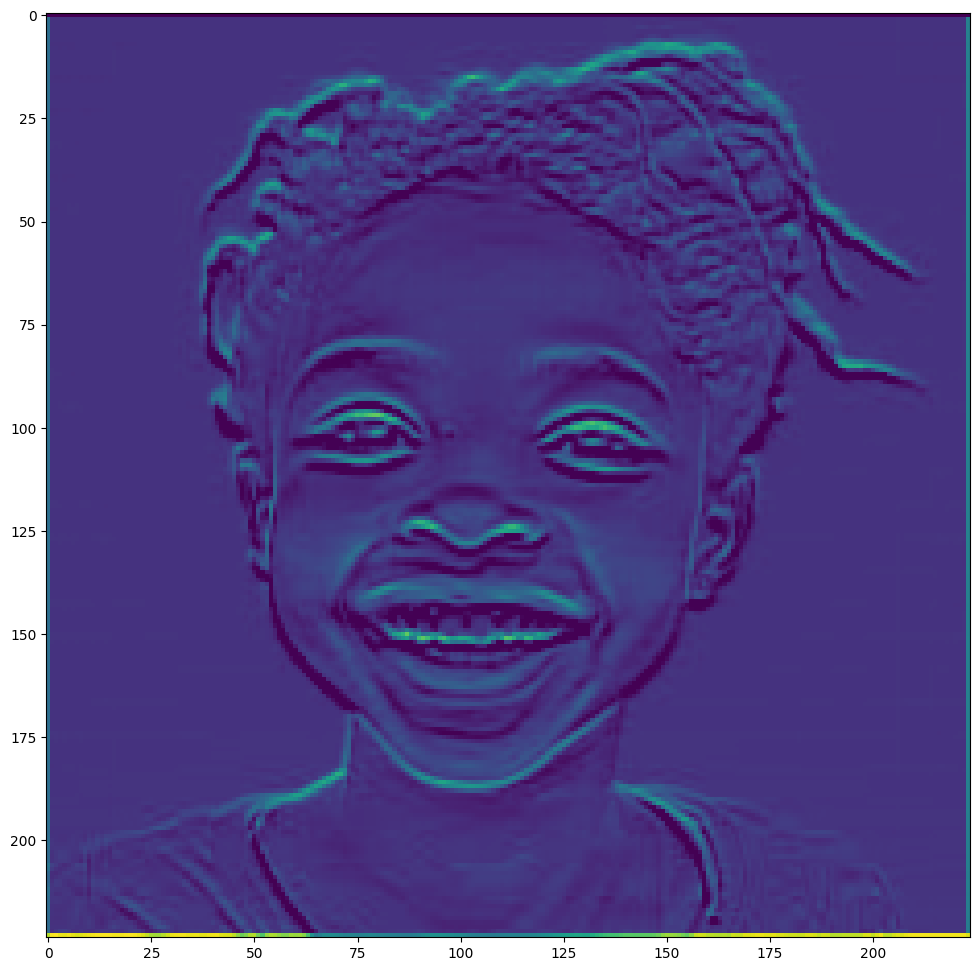

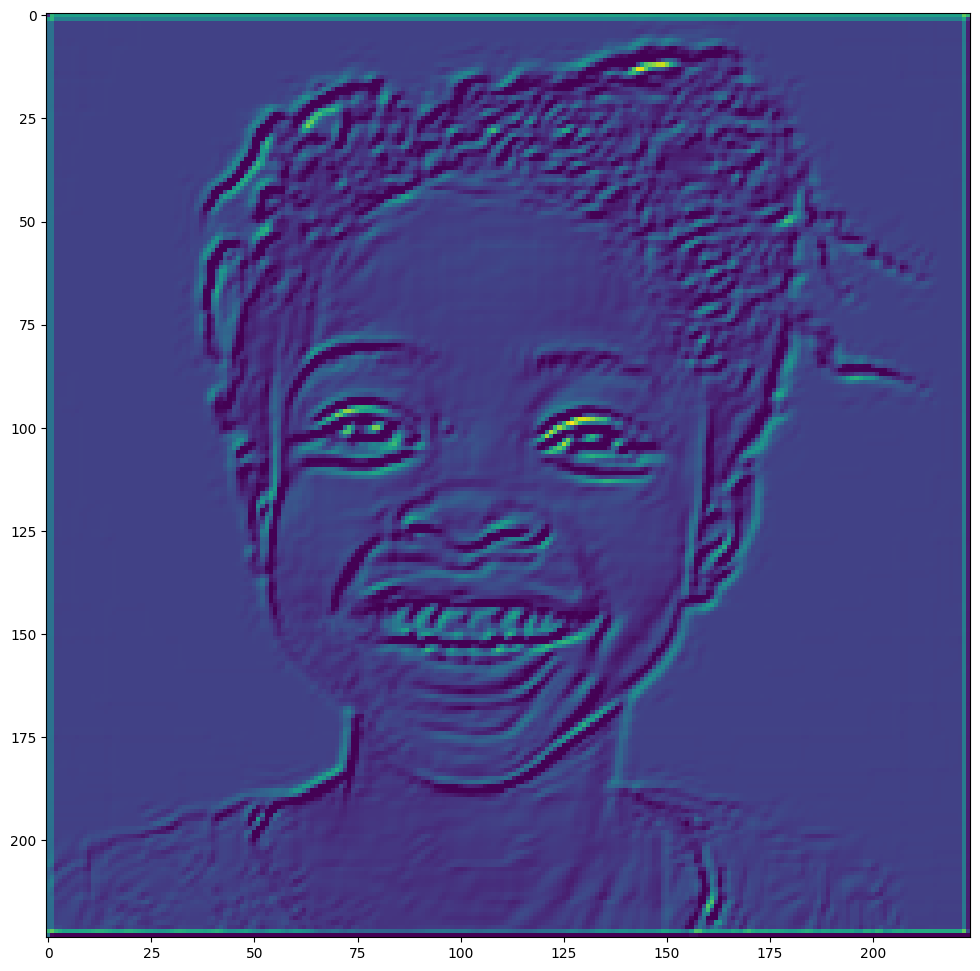

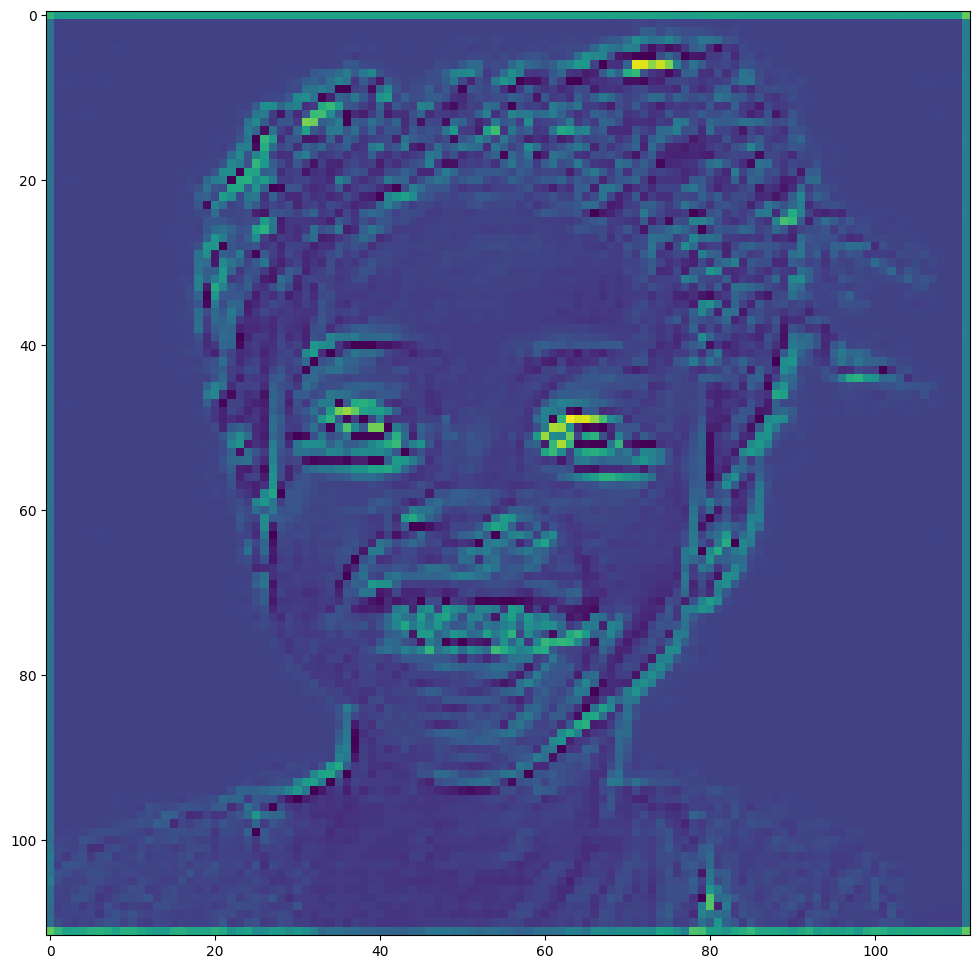

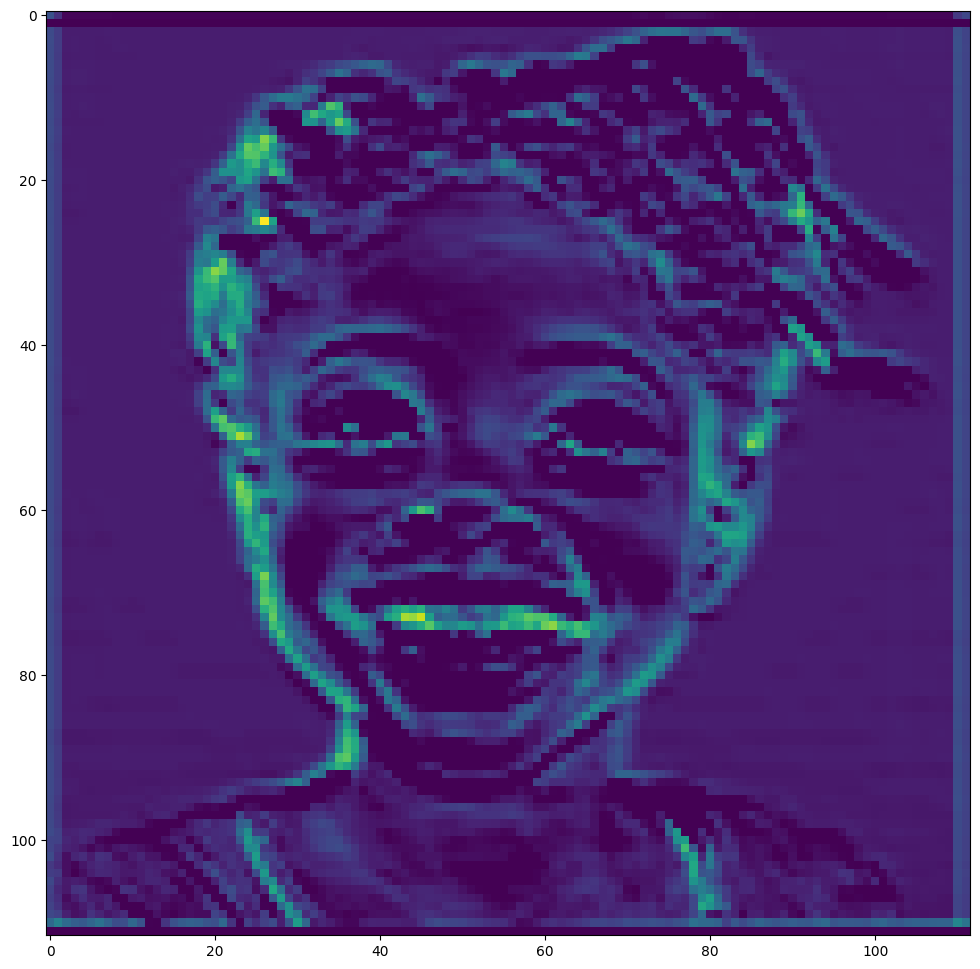

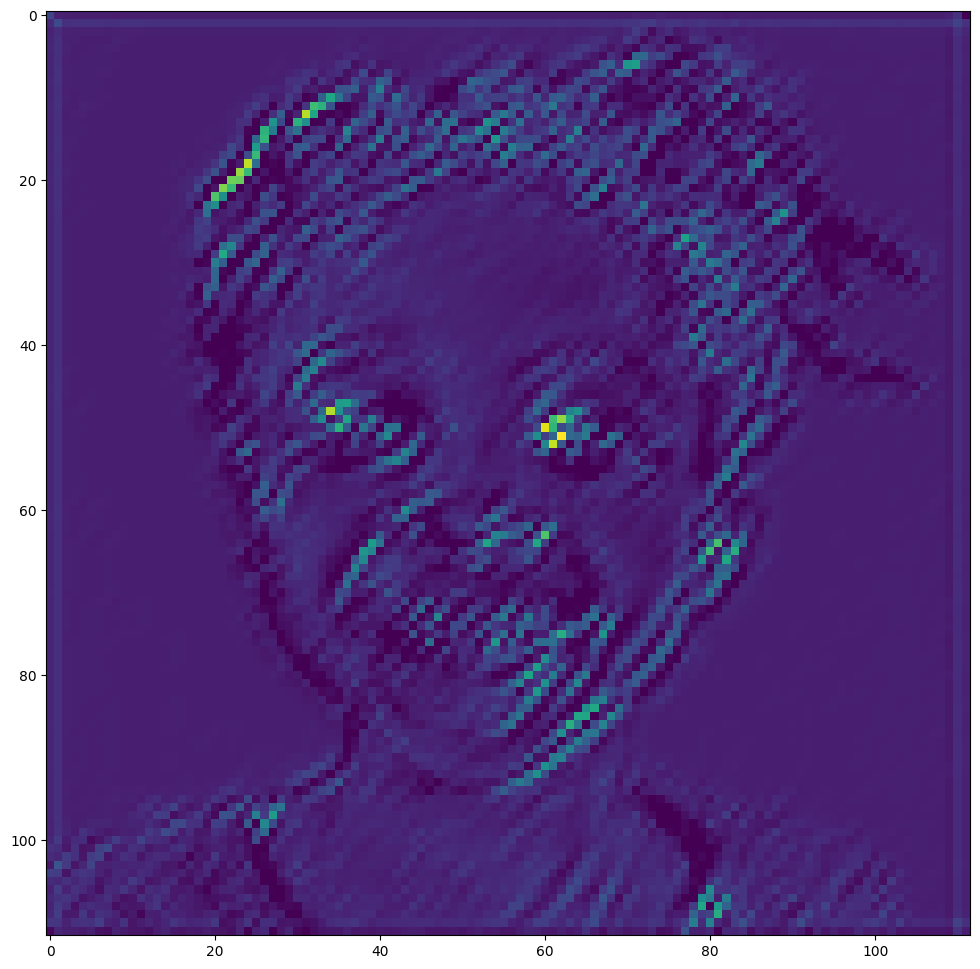

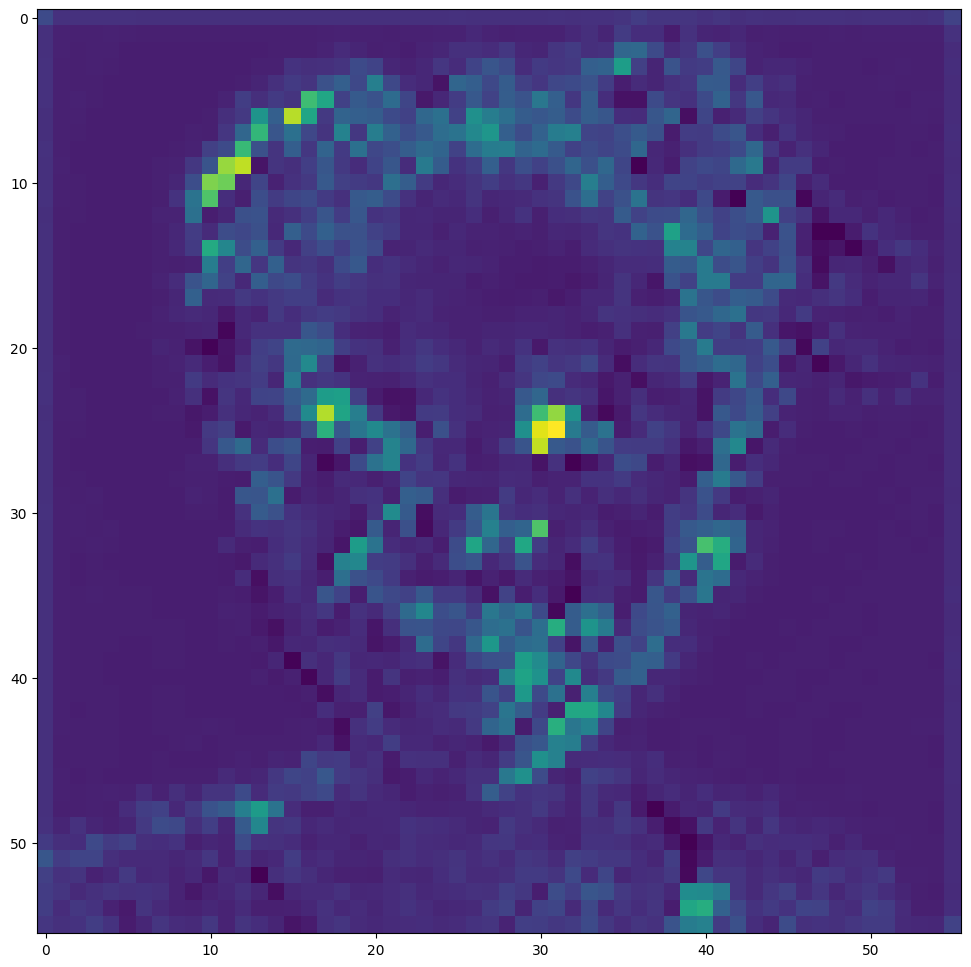

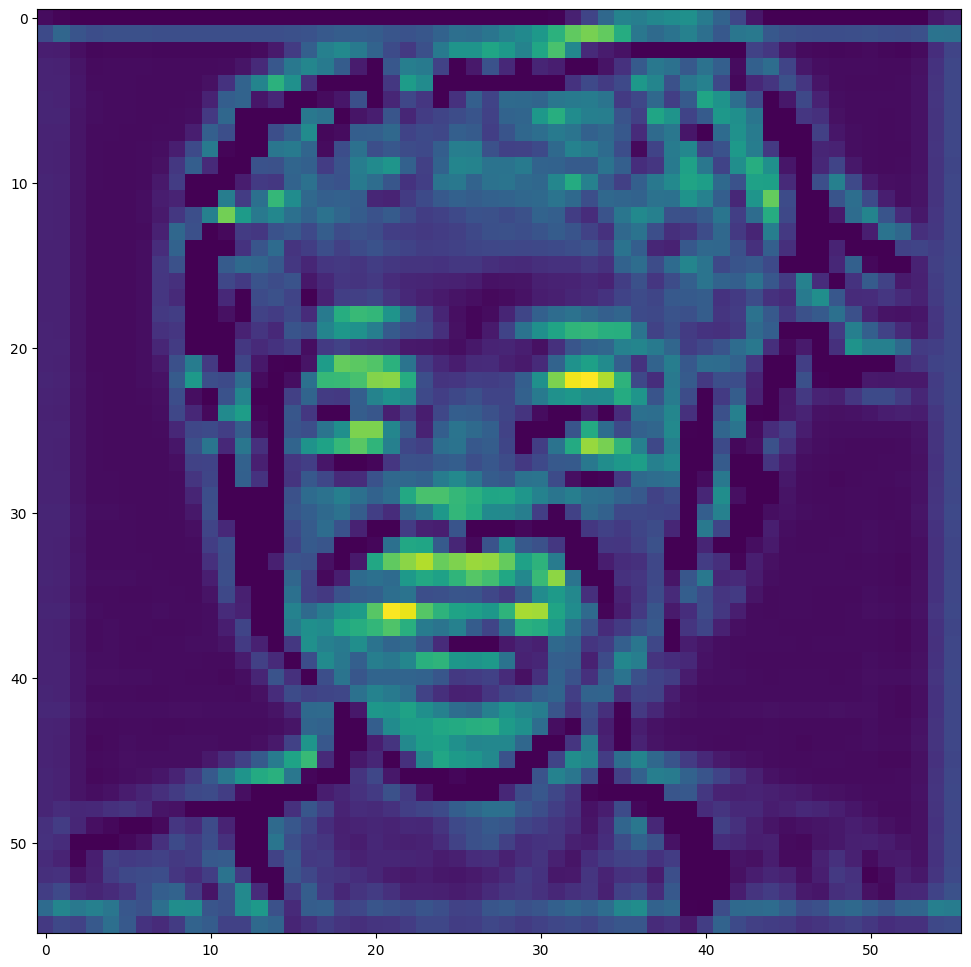

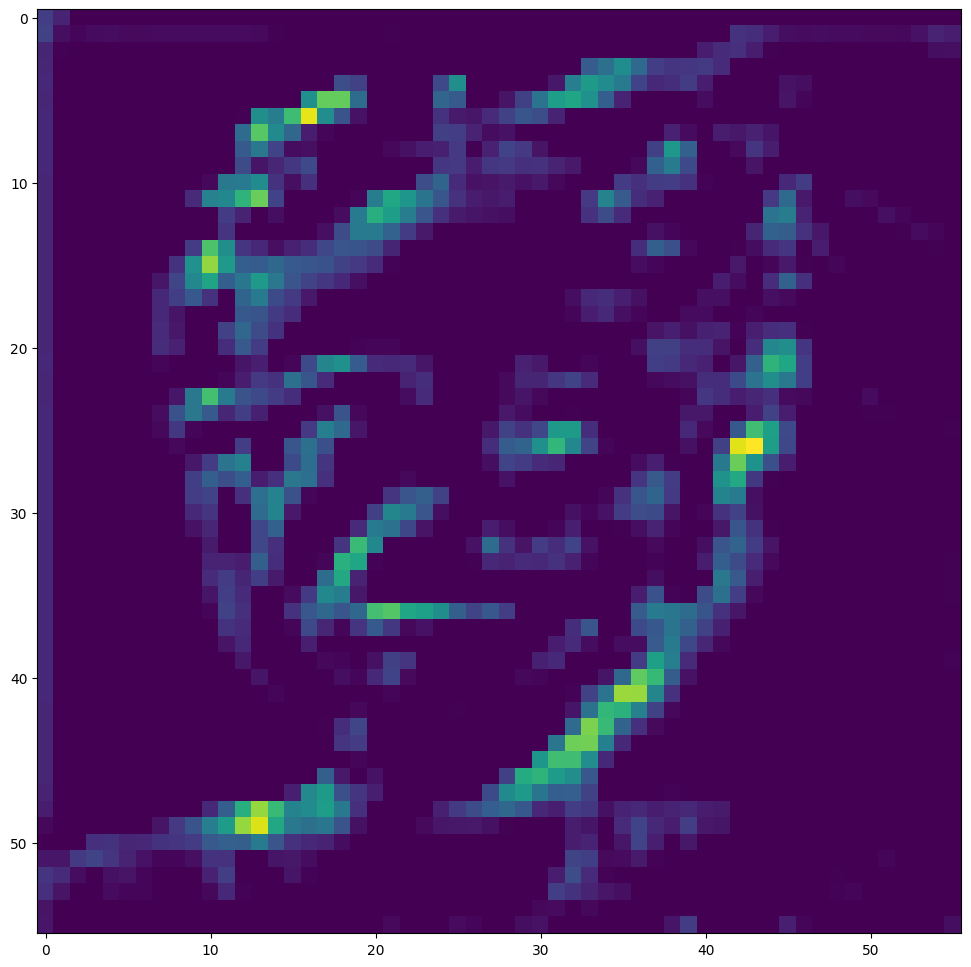

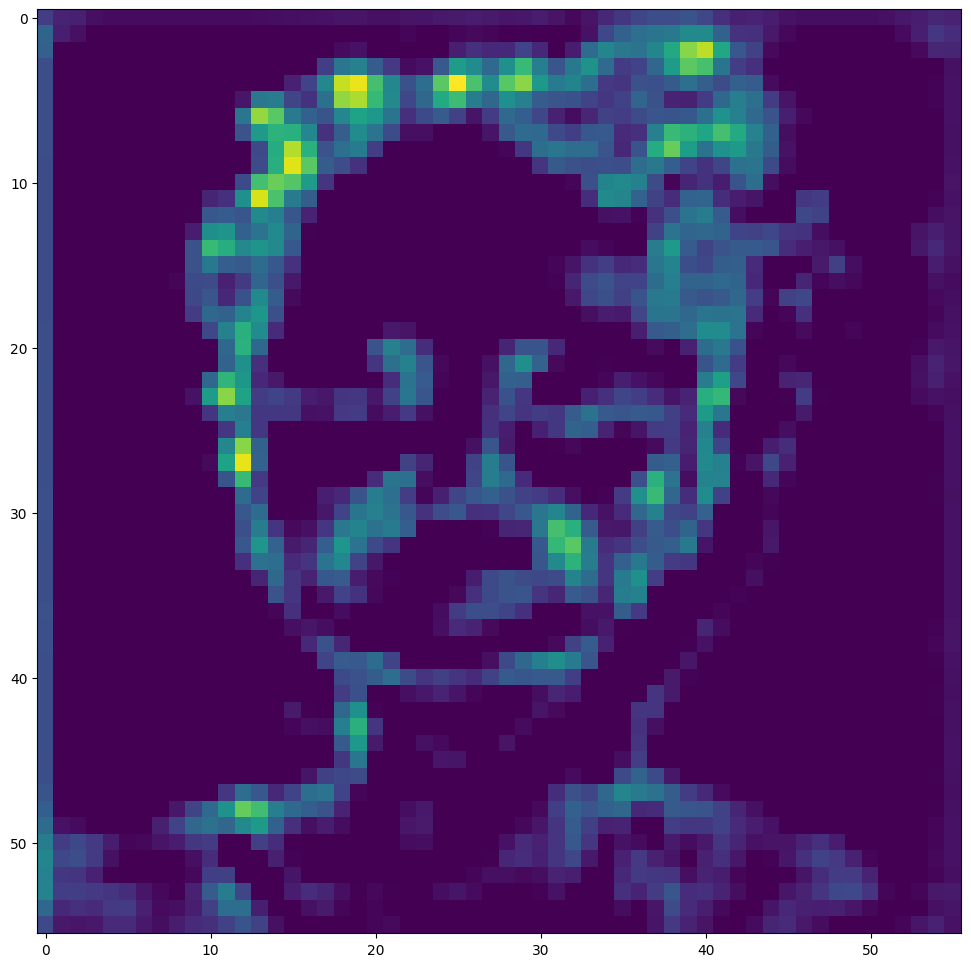

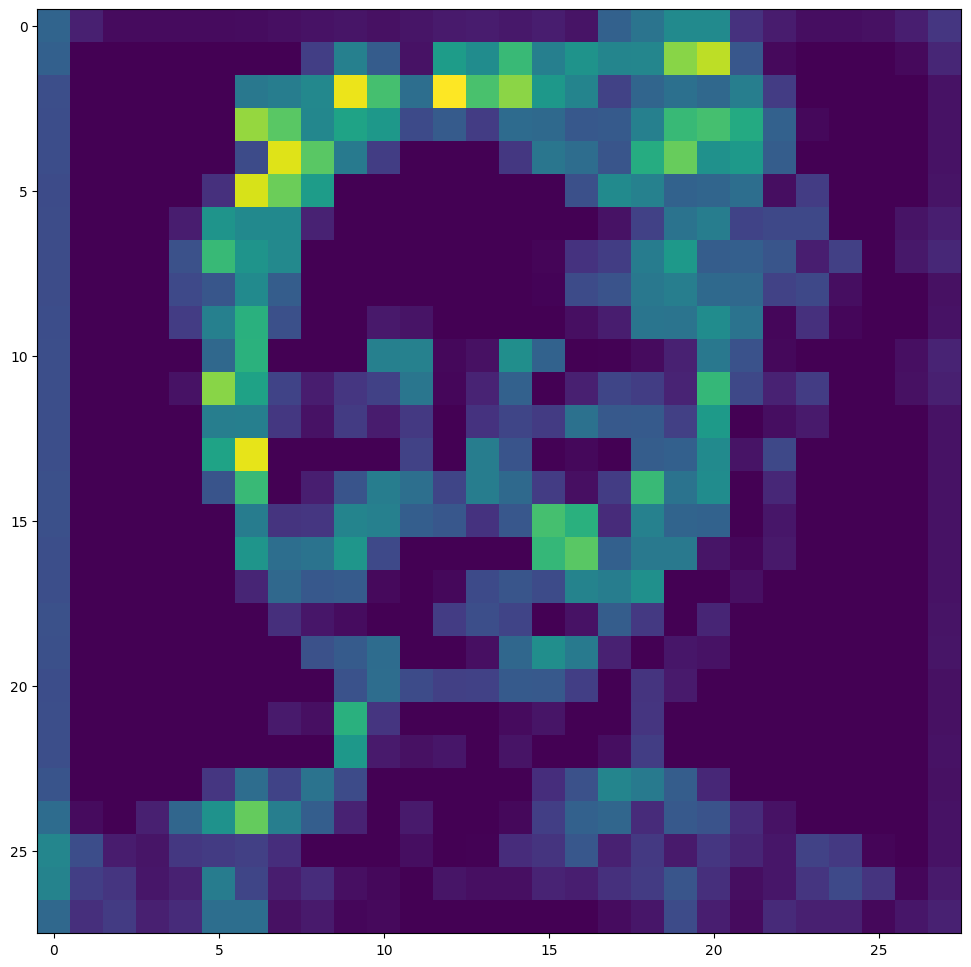

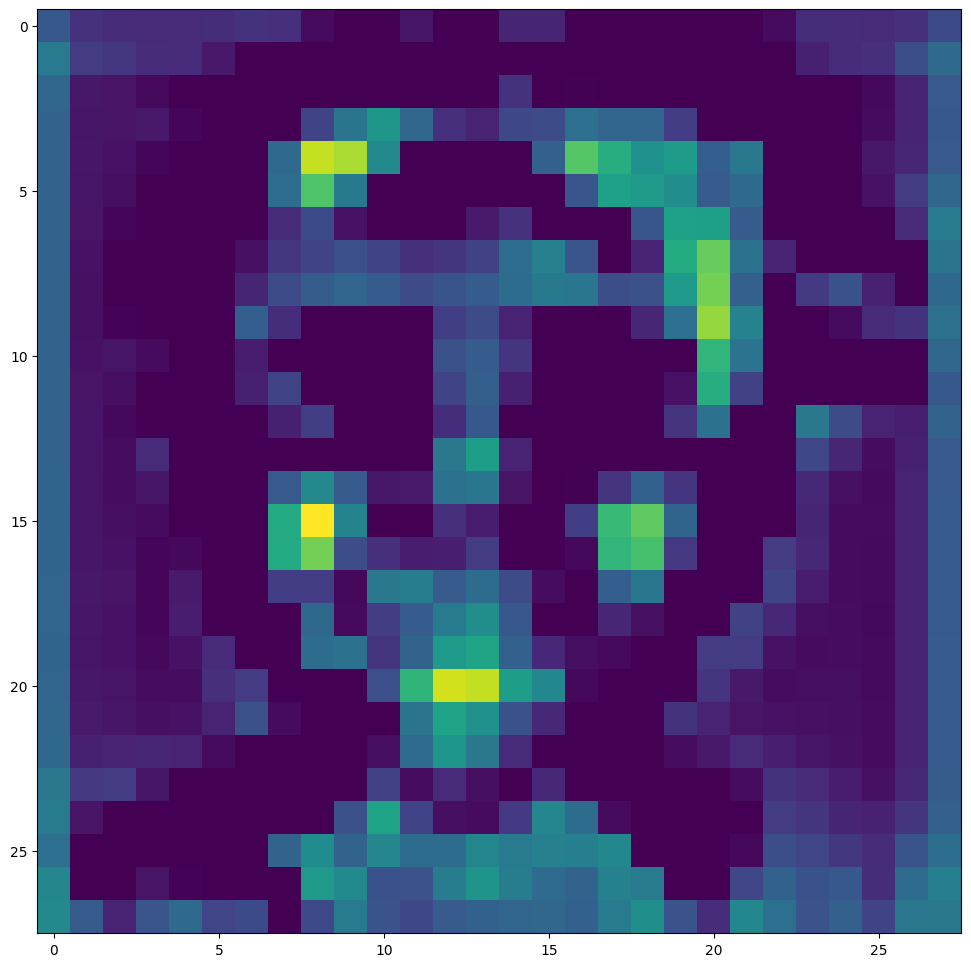

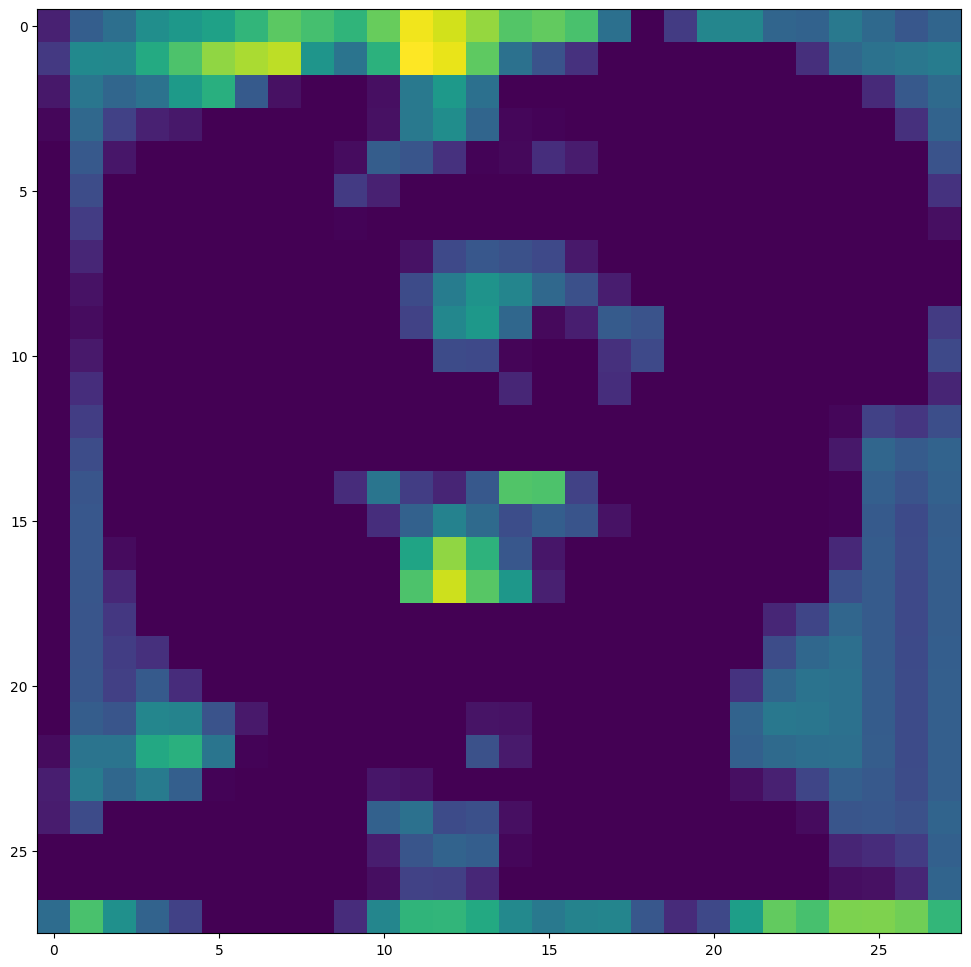

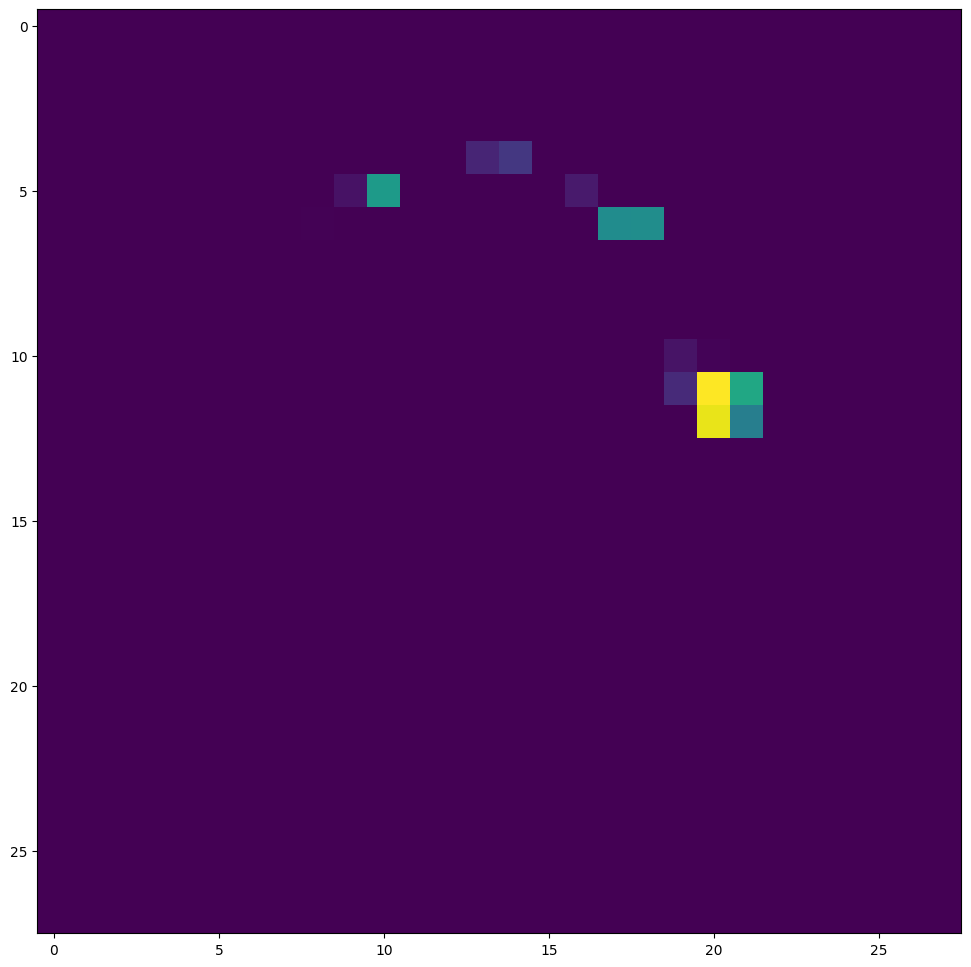

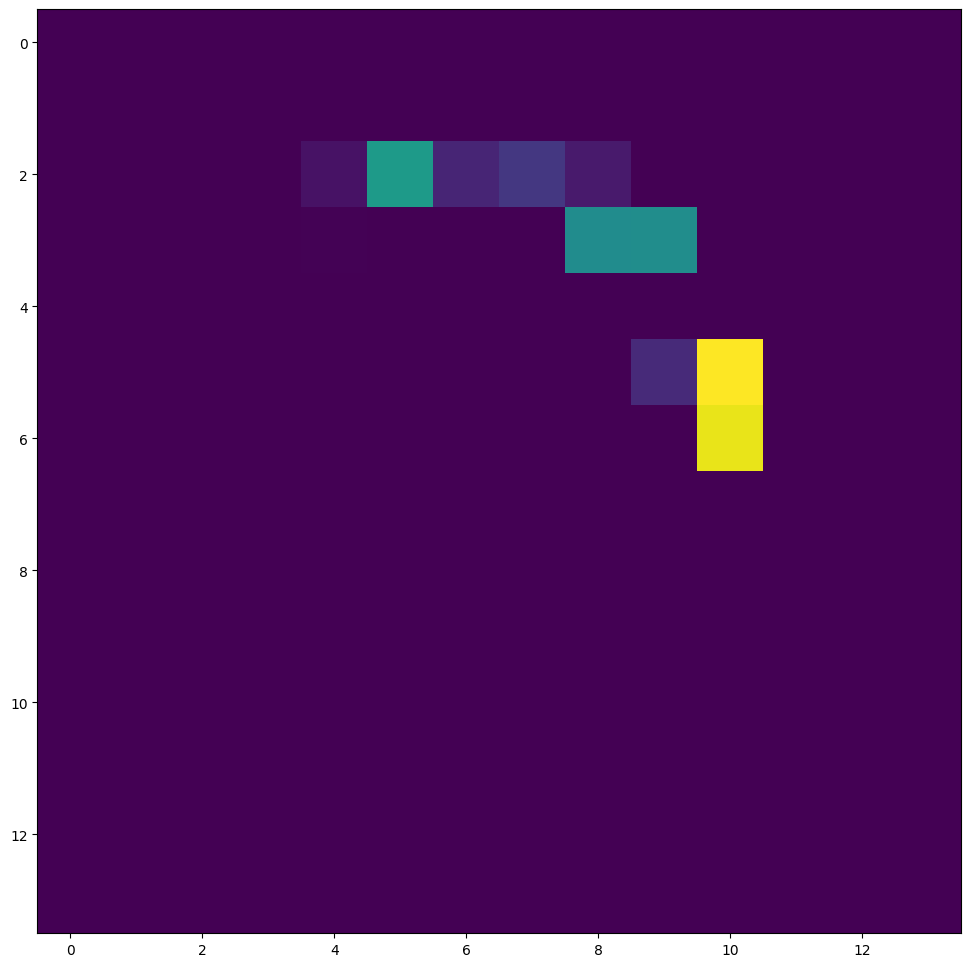

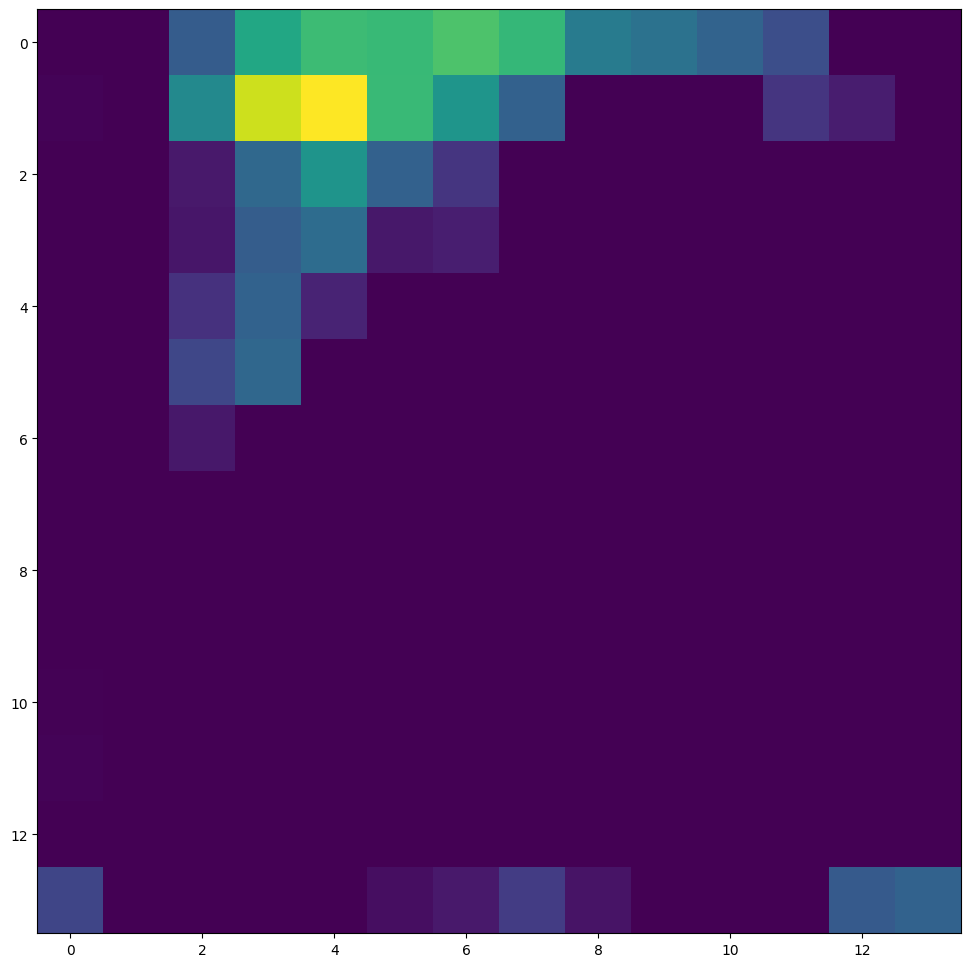

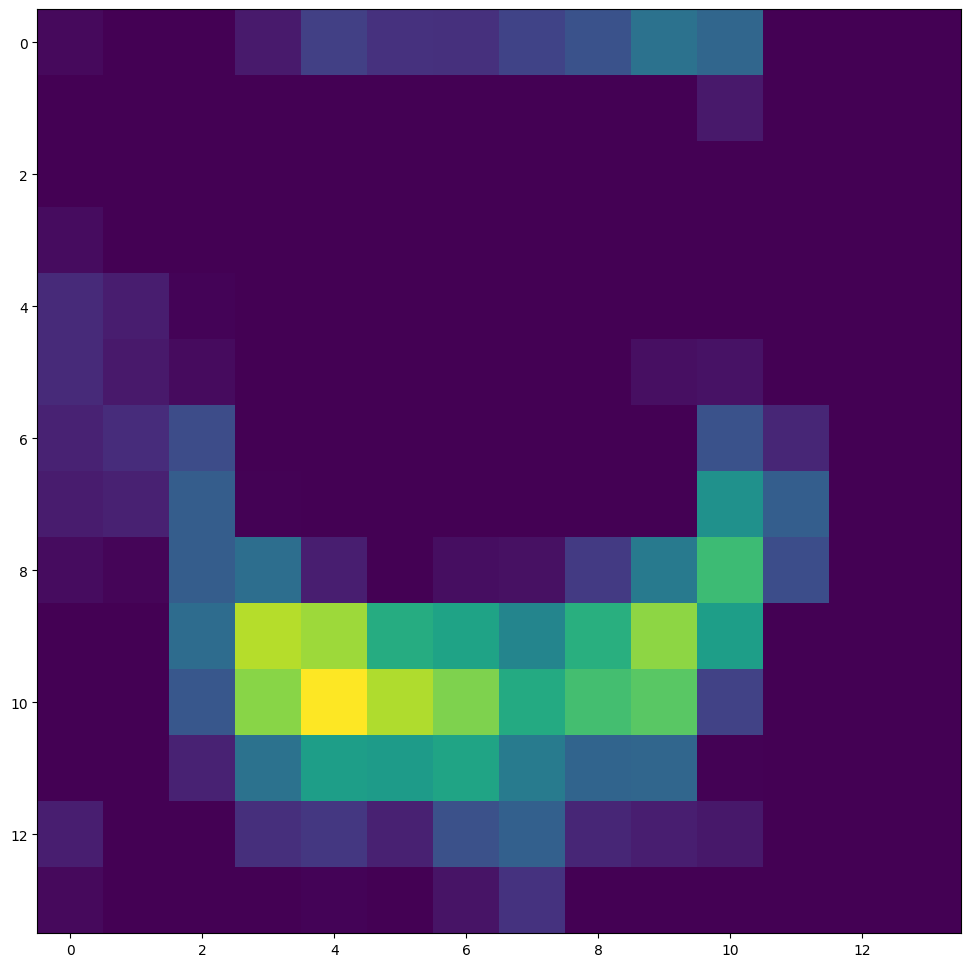

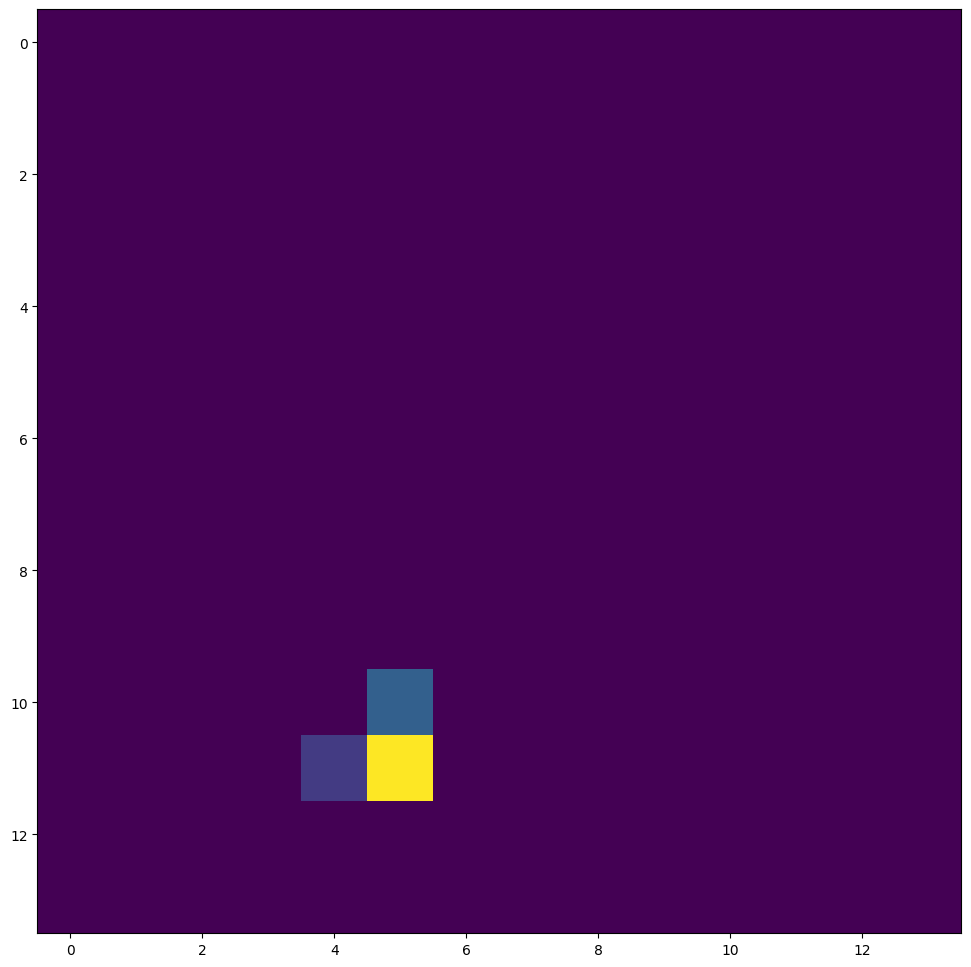

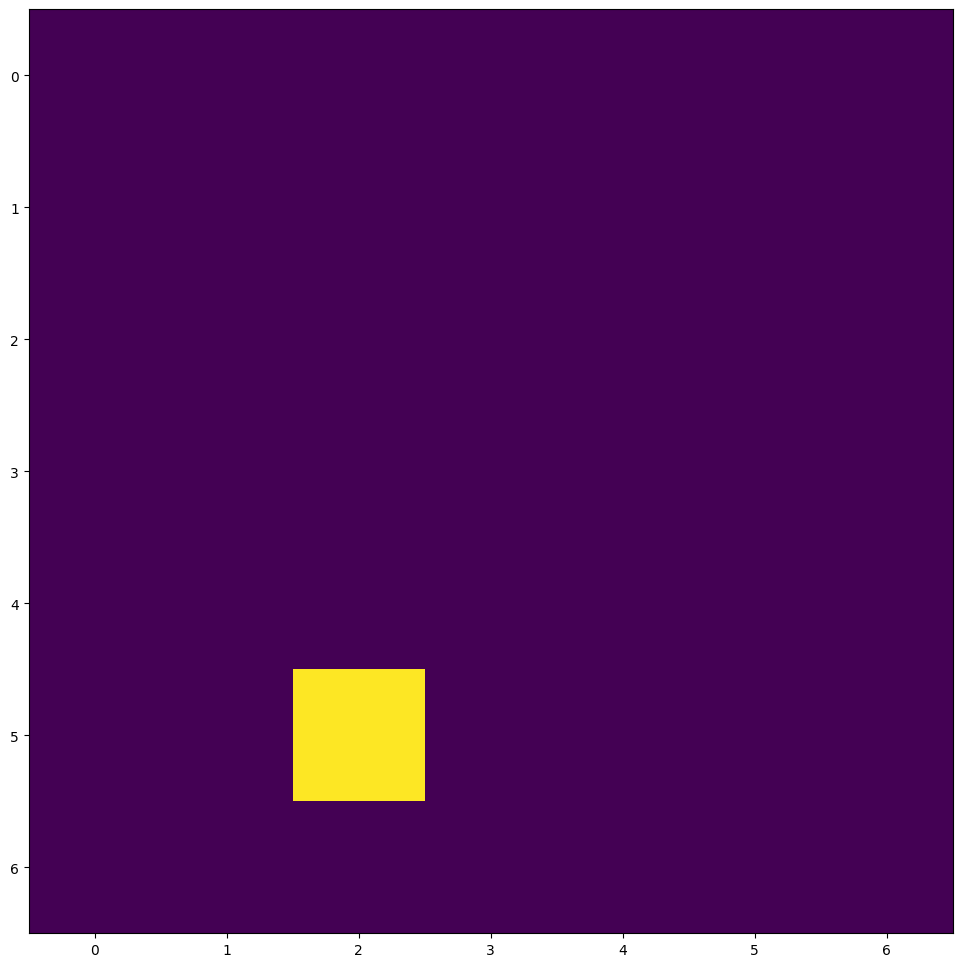

In [ ]:
for i in range(len(predicted)):
  plt.figure(figsize=(12,12))
  plt.imshow(predicted[i][0,:,:,10])
  plt.show()

In [ ]:
resnet34.save("resnetmodel", save_format='tf')


In [ ]:
mode=pickle.load(open("/content/effmodel.pkl", "rb"))
mode.summary()

ModuleNotFoundError: No module named 'keras.src.models.sequential'

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/resnetmodel")
model.summary()

Model: "resnet34model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 custom_conv2d (customconv)  multiple                  9728      
                                                                 
 max_pooling2d_6 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 custom_residual_block (res  multiple                  74368     
 idual)                                                          
                                                                 
 custom_residual_block (res  multiple                  74368     
 idual)                                                          
                                                     

In [ ]:
model.save("resnet.keras")

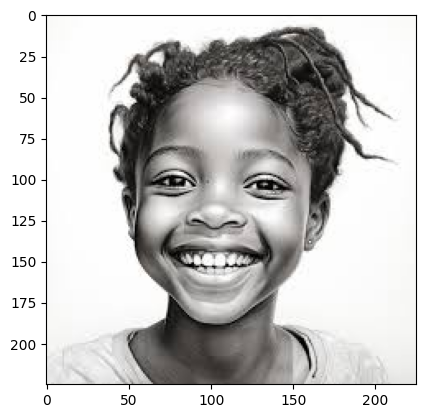

In [ ]:

img =plt.imread("/content/images-5.jpeg")
plt.imshow(img)

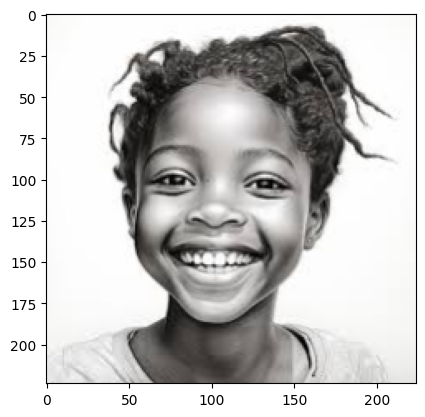

In [ ]:
img = tf.image.convert_image_dtype(img, dtype = tf.float32)
img = tf.image.resize(img, (224,224))
plt.imshow(img)
predicted=[]
predicted.append(model(tf.expand_dims(img, axis = 0)))

In [ ]:
print(classname[np.argmax(predicted[-1], axis = -1)])

angry


In [ ]:
alexmodel.evaluate(validdataset)

72/72 [==============================] - 93s 1s/step - loss: 1.1069 - cataccuracy: 0.5926 - top2accuracy: 0.8604


[1.1069022417068481, 0.592625081539154, 0.860403835773468]

In [ ]:
predicted=[]
predlabel=[]
for im, labels in validdataset:
  predicted.append(tf.argmax(model(im).numpy()))
  predlabel.append(tf.argmax(labels, axis = 0).numpy())

In [ ]:
print(np.argmax(predlabel[:-1],axis=-1))
print(np.argmax(predicted[:-1],axis=-1))

[0 2 2 1 2 1 0 2 0 0 1 0 0 0 2 0 0 2 2 0 2 0 0 2 0 0 0 1 2 2 2 1 0 0 1 2 1
 0 2 1 1 0 1 1 1 0 0 2 0 2 2 2 1 0 2 1 2 2 2 2 1 1 1 0 2 0 0 0 2 0 1]
[1 2 0 1 1 1 0 0 2 0 1 0 1 1 2 0 2 0 1 1 1 2 2 0 0 2 0 1 0 0 1 1 1 2 1 2 2
 1 1 2 2 0 0 0 0 1 2 0 1 2 1 1 0 1 2 1 1 1 2 2 1 1 2 2 1 0 1 1 1 2 2]


In [ ]:
true = np.argmax(predlabel[:-1],axis=-1)
pred = np.argmax(predicted[:-1],axis=-1)

[[ 9 11  5]
 [ 7  6  9]
 [ 7  6 11]]


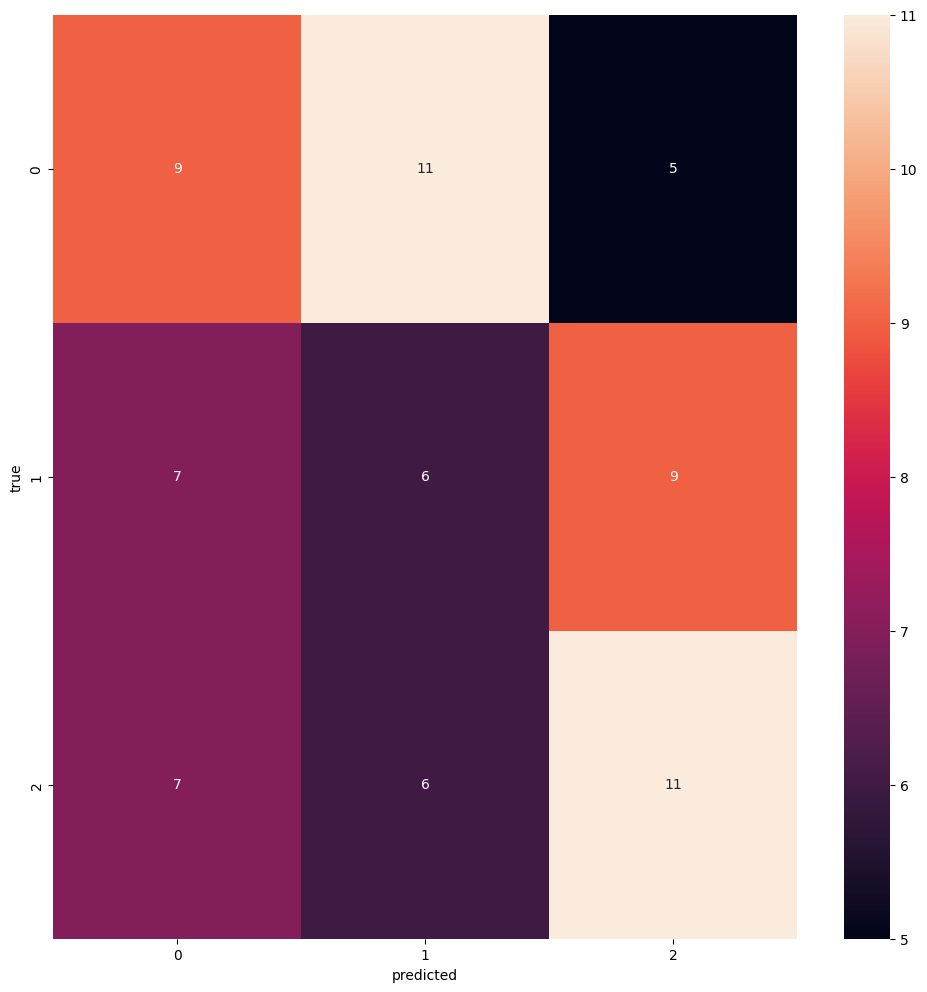

In [ ]:
cm = confusion_matrix(true, pred)
print(cm)
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot = True)
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()